# **Introduction to In-Context Learning Demo: Time-Series Prediction**

In this notebook we show how Large Language Models (LLMs) can learn **to predict and complete temporal, numerical sequences from a handful of examples**. Inspired by *[Large Language Models as General Pattern Machines](https://arxiv.org/pdf/2307.04721)* (Mirchandani et al., 2023), this experiment uses training data derived from sinusoidal functions and evaluates Gemini’s ability to recognize, internalize, and extrapolate the underlying behavior. The goal is to show how an LLM —**without being explicitly told the analytical form of the function**— can observe short temporal sequences and, in turn, complete a new test sequence beyond its original domain.

## **Overview**

This demonstration guides you through:
1.   Preparing training examples for in-context learning
2.   Constructing prompts containing these examples
3.   Querying the Gemini model to predict a time series
4. Generating extended values for a custom test sequence

The result is a clear visualization of how LLMs behave as pattern machines—even when dealing with mathematical patterns instead of grid transformations.

## **Background**
This demo focuses on sequences generated from two families of functions:
- a⋅x⋅sin(bx)
- a⋅sin(bx)

For each function type, we create 10 sample sequences, using x-values uniformly sampled from the interval [0,π]. These examples are given to the LLM as demonstrations of the kind of pattern we expect it to continue. What makes this setup interesting is that the model is not given the underlying analytical equations. In addition, the test sequence extends beyond the [0,π] range, challenging the model to generalize rather than memorize, i.e., the interpolation of values is not enough to generate good performance. This setting provides an intuitive benchmark of whether an LLM can identify the temporal behavior of a numerical time-series provided.

## **Let's Take a Look at an Example**

The illustration below shows a sample training sequence generated (red curve) from a sine-based function and a test sequence that slightly exceeds the seen interval. The model observes several patterns like this in the prompt. The test input challenges the LLM to extend the curve naturally, maintaining the oscillatory structure without explicit formulas or reasoning tools.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/sequence_completion_axsin(bx).gif" height="500">

## **LLM as the Optimizer**
In this demo, we use Gemini 2.0/2.5 Flash in non-reasoning mode. This ensures that the model focuses on pattern continuation rather than symbolic mathematics or deliberate reasoning. The workflow is simple:

- Provide several sine-based training sequences
- Append a new test sequence that extends beyond the sampled domain
- Ask the model to continue the sequence for 50, 100, or 200 additional time steps

The LLM acts as a pattern completion machine, detecting the structure from the examples and applying it to the test sequence. This approach highlights how LLMs can approximate functional behavior purely through in-context pattern recognition.

## **Code Overview**
The implementation is organized into a modular structure, with each component responsible for a different stage of the sequence prediction pipeline. This design separates data loading, visualization, prompt construction, LLM inference, and result interpretation, making the system easy to understand, modify, and extend.

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**



In [ ]:
#@title **Import Necessary Libraries**
import numpy as np
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
import re
import itertools
import math
import ast
import getpass
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
import ipywidgets as widgets

In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")
client = genai.Client(api_key=apikey)

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash")
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

### **Let's Take a Look at an Example of the Prompt (applies to both examples!):**
```
You are given several example sequences of (x, y) pairs generated by different mathematical patterns.

Example 1: [(0.0, 0.0), (0.025, 0.199), (0.05, 0.389), ...]
Example 2: [(0.0, 0.0), (0.025, 0.397), (0.05, 0.779), ...]
Example 3: [(0.0, 0.0), (0.025, 0.596), (0.05, 1.168), ...]
Example 4: [(0.0, 0.0), (0.025, 0.795), (0.05, 1.558), ...]
Example 5: [(0.0, 0.0), (0.025, 0.993), (0.05, 1.947), ...]
Example 6: [(0.0, 0.0), (0.025, 1.192), (0.05, 2.337), ...]
...

The following sequence represents a partial test input: {test}

Now generate the next 200 new (x, y) pairs that follow the same underlying mathematical pattern, continuing
naturally from where the test sequence ends.

Output a  Python list of (x, y) pairs in this format, remember to close all brackets correctly:
[(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5), ...]
No explanations, no code, no comments — only the list.
```

The above prompt shows several training examples and one test query from a time series prediction task, where each example provides a short list of (x,y) pairs generated by a particular mathematical pattern (in this case, sinusoidal curves with different amplitudes or phases). Each example demonstrates how the values evolve as x increases, and the corresponding y-values reflect the underlying function that produced the sequence. The model’s objective is to infer this hidden generative rule solely from the provided examples and then apply it to the partial test sequence in order to produce the next 200 (x,y) pairs.

This is considered ICL because the weights of the LLM model are not updated or fine-tuned to the training data. All “learning” occurs within the prompt itself: the example sequences become the model’s temporary training data. By observing the input–output behavior embedded in the prompt, the LLM identifies the shared mathematical pattern, generalizes it, and continues the test sequence beyond its given domain—all during a single forward pass of the LLM. In other words, the model learns from context, not from parameter updates.

# **First Example: a⋅x⋅sin(bx)**

The below cell **`Example Generation`** is responsible for the generating the example sequences for the sequence prediction demo. It's purpose is to output  sequences of transformations of the orignal a⋅x⋅sin(bx) function

In [ ]:
#@title **Example Generation**
def generate_example(amplitude):
    x = np.round(np.arange(0, 2*np.pi, 0.025), 3).tolist()
    y = np.round(amplitude * np.array(x) * np.sin(frequency * np.array(x)), 3).tolist()
    return list(zip(x, y))

The two cells below: **`Sequence Prediction of a⋅x⋅sin(bx)`** and **`Demo`** are responsible for running the full sequence-completion demo, including example generation, prompt construction, LLM inference, output parsing, and returning the predicted values. It effectively acts as the end-to-end execution layer for the entire notebook. The cell generates a set of example sequences based on variations of the ax·sin(bx) function and formats them into a prompt shown to the LLM. It then takes a user-supplied partial test sequence and asks the model to extend it by producing the next 50/100/200 (x, y) pairs that follow the same underlying mathematical pattern.

The function performs the following steps:
1. Takes input of frequency, amplitude, x_start, and x_end from the user
2. Creates ten example sequences using those parameter values,
3. Formats all examples and the test input into a structured LLM prompt,
4. Sends the prompt to Gemini 2.5-Flash for sequence completion,
5. Cleans and parses the raw model output into valid Python data,
6. Extracts the resulting x-values and y-values for downstream visualization.

The function will then visualize the output as an animated plot. The plot contains the original example sequences (solid gray curve), the model-generated continuation (red curve), as well as the ground-truth or expected values (dashed gray curve).

In [ ]:
#@title **Sequence Prediction of ax⋅sin(bx)**
def sequence_completion_demo(frequency, test):
    examples = [generate_example(a) for a in range(1, 11)]

    examples_text = "\n".join([f"Example {i+1}: {ex}" for i, ex in enumerate(examples)])

    prompt = f"""
    You are given several example sequences of (x, y) pairs generated by different mathematical pattern.

    {examples_text}

    The following sequence represents a partial test input: {test}

    Now generate the next 200 new (x, y) pairs that follow the same underlying mathematical pattern, continuing naturally from where the test sequence ends.

    Output a  Python list of [x, y] pairs in this format, remember to close all brackets correctly:
    [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5), ..., ..., ...]
    No explanations, no code, no comments — only the list.
    """

    response = client.models.generate_content(
        model=model_name,
        contents=[prompt],
        config=types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(thinking_budget=0)
        ),
    )

    cleaned_response = response.text
    cleaned_response = cleaned_response.replace("python","").replace("```","").replace("json","")

    points = ast.literal_eval(cleaned_response.strip())
    x_values = [x for x, y in points]
    y_values = [y for x, y in points]
    return x_values, y_values

Enter sample amplitude (e.g. 2): 5
Enter sample frequency (e.g. 8): 10
Enter start x value (e.g. 2): 2
Enter end x value (e.g. 3): 3


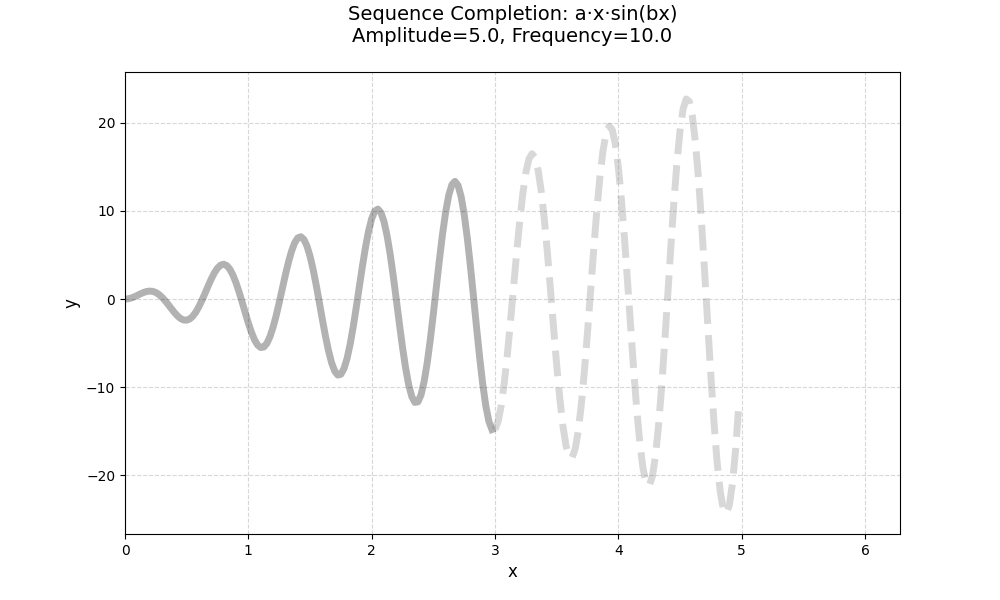

In [ ]:
#@title **Demo**
amplitude = float(input("Enter sample amplitude (e.g. 2): "))
frequency = float(input("Enter sample frequency (e.g. 8): "))
x_start = float(input("Enter start x value (e.g. 2): "))
x_end = float(input("Enter end x value (e.g. 3): "))

x_test = np.round(np.arange(x_start, x_end, 0.025), 3)
y_test = np.round(amplitude * x_test * np.sin(frequency * x_test), 3)

test = [(float(x), float(y)) for x, y in zip(x_test, y_test)]

x_pred, y_pred = sequence_completion_demo(frequency, test)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, max(x_end + 2, 2 * np.pi))
ax.set_ylim(min(y_pred[:100]), max(y_pred[:100]))
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title(f"\nSequence Completion: a·x·sin(bx)\nAmplitude={amplitude}, Frequency={frequency}\n", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Ground truth curve
x_truth = np.arange(0, x_end, 0.025)
y_truth = amplitude * x_truth * np.sin(frequency * x_truth)
ax.plot(x_truth, y_truth, color="black", alpha=0.3, linewidth=5,  label="Ground Truth")

x_truth_2 = np.arange(x_end, x_end+2, 0.025)
y_truth_2 = amplitude * x_truth_2 * np.sin(frequency * x_truth_2)
ax.plot(x_truth_2, y_truth_2, color="gray", linestyle = "dashed", alpha=0.3, linewidth=5,  label="Ground Truth")

# Initialize animated line
(pred_line,) = ax.plot([], [], color="red", linewidth=5, label="Predicted Sequence")

# --- Update function for animation ---
def update(frame):
    pred_line.set_data(x_pred[:frame], y_pred[:frame])
    return pred_line,

# --- Create animation ---
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(x_pred),
    interval=30,  # milliseconds between frames
    blit=True
)

# --- Save as GIF ---
gif_path = "sequence_completion.gif"
ani.save(gif_path, writer="pillow", fps=30)

plt.close(fig)  # close static plot to avoid double output

# --- Display inline (works in notebooks) ---
display(Image(filename=gif_path))



# **Second Example: a⋅sin(bx)**

This second  cell `Example Generation` is the same as the first and is also responsible for the generating the example sequences for the sequence prediction demo. However, it outputs the sequences of transformations of the orignal `a⋅sin(bx)` function

In [ ]:
#@title **Example Generation**
def generate_example_2(amplitude):
    x = np.round(np.arange(0, 2*np.pi, 0.025), 3).tolist()
    y = np.round(amplitude * np.sin(frequency * np.array(x)), 3).tolist()
    return list(zip(x, y))
# Reset Gemini Client
client = genai.Client(api_key=apikey)

The two cells below: **`Sequence Prediction of a⋅sin(bx)`** and **`Demo`** is responsible for running the full sequence-completion demo, including example generation, prompt construction, LLM inference, output parsing, and returning the predicted continuation. It effectively acts as the end-to-end execution layer for the entire notebook.

The cell generates a set of example sequences based on variations of the ax·sin(bx) function and formats them into a prompt shown to the model. It then takes a user-supplied partial test sequence and asks the model to extend it by producing the next 50/100/200 (x, y) pairs that follow the same underlying mathematical pattern.

The function performs the following steps:
1. Takes input of frequency, amplitude, x_start, and x_end from the user
2. Creates ten example sequences using those parameter values,
3. Formats all examples and the test input into a structured LLM prompt,
4. Sends the prompt to Gemini 2.5-Flash for sequence completion,
5. Cleans and parses the raw model output into valid Python data,
6. Extracts the resulting x-values and y-values for downstream visualization.

The function will then visualize the output as an animated plot and contain:
- The original example sequences (solid gray curve)
- The model-generated continuation (red curve)
- The ground-truth or expected values (dashed gray curve)

In [ ]:
#@title **Sequence Prediction of a⋅sin(bx) using Gemini 2.5-Flash**
def sequence_completion_2(frequency, test):
    examples = [generate_example_2(a) for a in range(1, 11)]

    examples_text = "\n".join([f"Example {i+1}: {ex}" for i, ex in enumerate(examples)])

    prompt = f"""
    You are given several example sequences of (x, y) pairs generated by different mathematical pattern.

    {examples_text}

    The following sequence represents a partial test input: {test}

    Now generate the next 100 new (x), y) pairs that follow the same underlying mathematical pattern, continuing naturally from where the test sequence ends.

    Output a  Python list of [x, y] pairs in this format, remember to close all brackets correctly:
    [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5), ..., ..., ...]
    No explanations, no code, no comments — only the list.
    """

    # --- Gemini Query ---
    response = client.models.generate_content(
        model=model_name,
        contents=[prompt],
        config=types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(thinking_budget=0)
        ),
    )

    cleaned_response = response.text
    cleaned_response = cleaned_response.replace("python","").replace("```","").replace("json","")
    # --- Parse model response safely ---
    points = ast.literal_eval(cleaned_response.strip())
    x_values = [x for x, y in points]
    y_values = [y for x, y in points]
    return x_values, y_values

Enter sample amplitude (e.g. 2): 2
Enter sample frequency (e.g. 8): 8
Enter start x value (e.g. 2): 2
Enter end x value (e.g. 3): 5


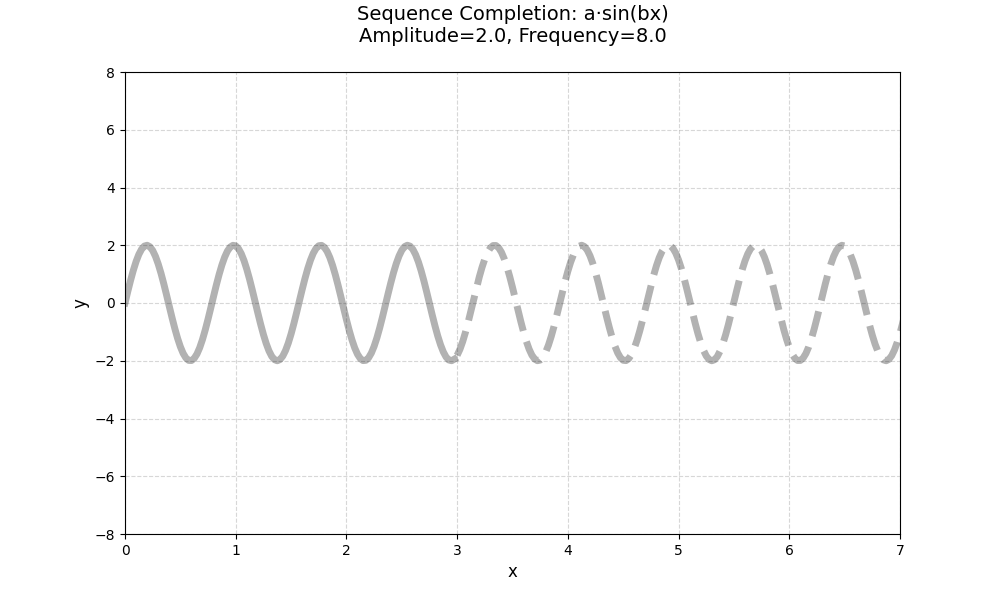

In [ ]:
#@title **Demo**
amplitude = float(input("Enter sample amplitude (e.g. 2): "))
frequency = float(input("Enter sample frequency (e.g. 8): "))
x_start = float(input("Enter start x value (e.g. 2): "))
x_end = float(input("Enter end x value (e.g. 3): "))

x_test = np.round(np.arange(x_start, x_end, 0.025), 3)
y_test = np.round(amplitude * np.sin(frequency * x_test), 3)

test = [(float(x), float(y)) for x, y in zip(x_test, y_test)]

x_pred, y_pred = sequence_completion_2(amplitude, test)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, max(x_end + 2, 2 * np.pi))
ax.set_ylim(min(y_pred[:100]), max(y_pred[:100]))
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title(f"\nSequence Completion: a·sin(bx)\nAmplitude={amplitude}, Frequency={frequency}\n", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Ground truth curve
x_truth = np.arange(0, x_end, 0.025)
y_truth = amplitude * np.sin(frequency * x_truth)
ax.plot(x_truth, y_truth, color="black", alpha=0.3, linewidth=5,  label="Ground Truth")

x_truth_2 = np.arange(x_end, x_end+2, 0.025)
y_truth_2 = amplitude * np.sin(frequency * x_truth_2)
ax.plot(x_truth_2, y_truth_2, color="black", linestyle = "dashed", alpha=0.3, linewidth=5)

# Initialize animated line
(pred_line,) = ax.plot([], [], color="red", linewidth=5, label="Predicted Sequence")

# --- Update function for animation ---
def update(frame):
    pred_line.set_data(x_pred[:frame], y_pred[:frame])
    return pred_line,

# --- Create animation ---
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(x_pred),
    interval=30,  # milliseconds between frames
    blit=True
)

# --- Save as GIF ---
gif_path = "sequence_completion_2.gif"
ani.save(gif_path, writer="pillow", fps=30)

plt.close(fig)  # close static plot to avoid double output

# --- Display inline (works in notebooks) ---
display(Image(filename=gif_path))

## **Summary**

This demo illustrates how LLMs can perform in-context learning by recognizing and extending mathematical patterns from a limited set of numerical examples. By generating sample sequences from sine-based functions and presenting them as few-shot demonstrations, we query the model to infer the underlying oscillatory structure without any explicit description of the equations involved. When prompted with a new test sequence (one that extends slightly beyond the domain of the training examples) the model is asked to continue it for dozens or even hundreds of additional steps. Although predicted sequences don't always yield 100% accuracy on all results, the trends/pattern of the predicted values always remain similar. Through this setup, we observe how the LLM captures the sinusoidal behavior embedded in the examples, relying on pattern induction rather than formal symbolic reasoning.

Beyond the specific sine functions used here, the same methodology can be applied to a wide variety of numerical or functional patterns **(! spoiler: there's one demo similar to this)**. By crafting appropriate few-shot demonstrations, LLMs can be guided to model polynomial trends, exponential growth, periodic signals, noisy measurements, mixed-frequency curves, or even synthetic data constructed from custom rules. These extensions demonstrate the flexibility of the in-context learning framework when applied to continuous, mathematical, or time-series data, revealing how LLMs can generalize from limited examples to produce coherent and often surprisingly accurate continuations.

## **Conclusion**

This demonstration highlights that LLMs can generalize structured numerical behavior using only a handful of examples thereby capturing the essence of in-context learning in the domain of sequence prediction. Even without access to symbolic expressions, internal formulas, or explicit reasoning tools, the model can infer the qualitative shape of sine-like functions and extend them beyond the observed interval. While the LLM does not perform rigorous mathematical computation, its ability to internalize and reproduce oscillatory patterns shows strong potential for tasks requiring rapid approximation, pattern continuation, or short-range forecasting. Sequence prediction thus serves as a compelling testbed for understanding both the strengths and limitations of treating LLMs as general pattern machines.

## **References**
Mirchandani, S., Xia, F., Florence, P., Ichter, B., Driess, D., Arenas, M.G., Rao, K., Sadigh, D. and Zeng, A. (2023, December). Large Language Models as General Pattern Machines. *In Conference on Robot Learning* (pp. 2498-2518). PMLR.